In [1]:
from __future__ import absolute_import, division, print_function

import os, sys
import numpy as np
import pandas as pd
import cv2

from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
from time import time
from time import sleep
from matplotlib import pyplot as plt

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

Working with 542 signature images
Image examples: 
1_00105001.png


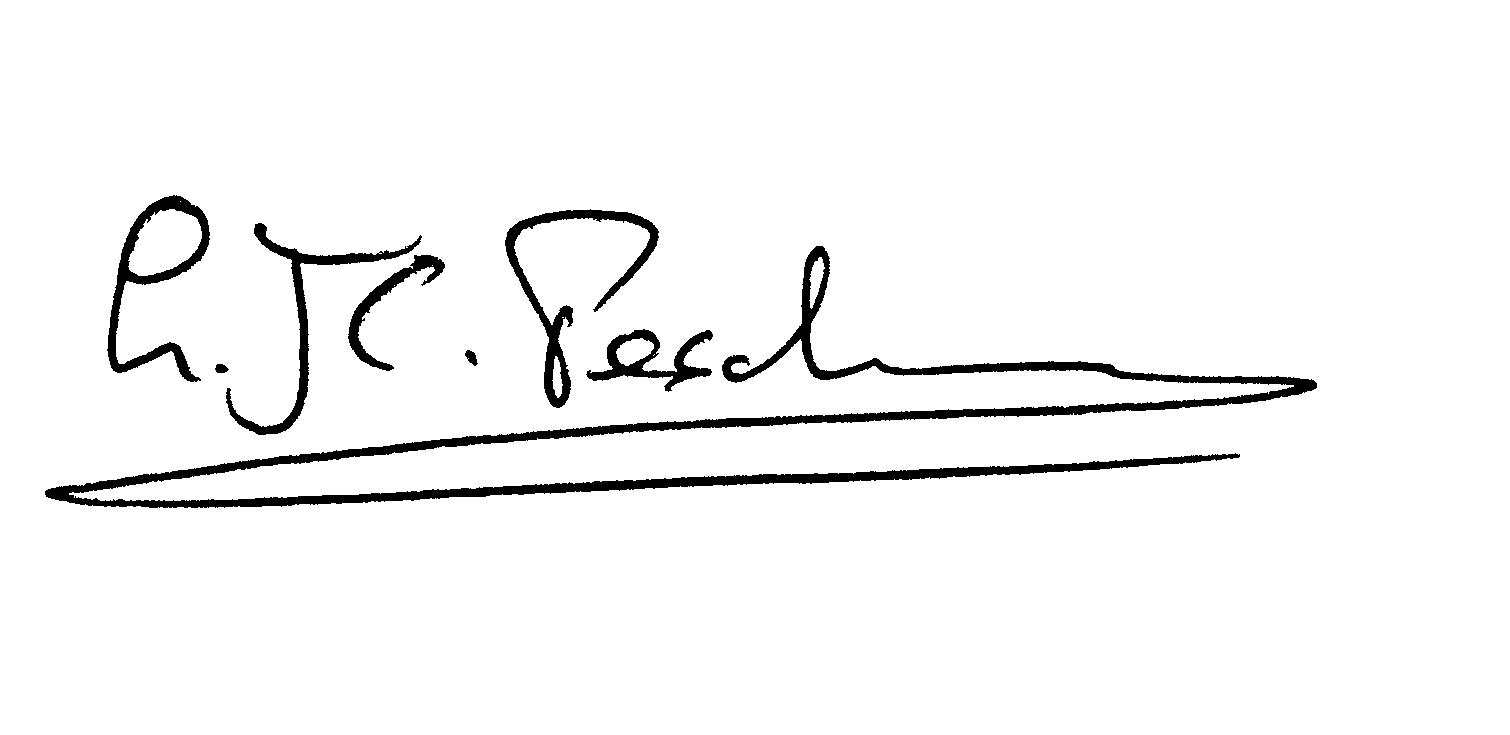

0_02202001.png


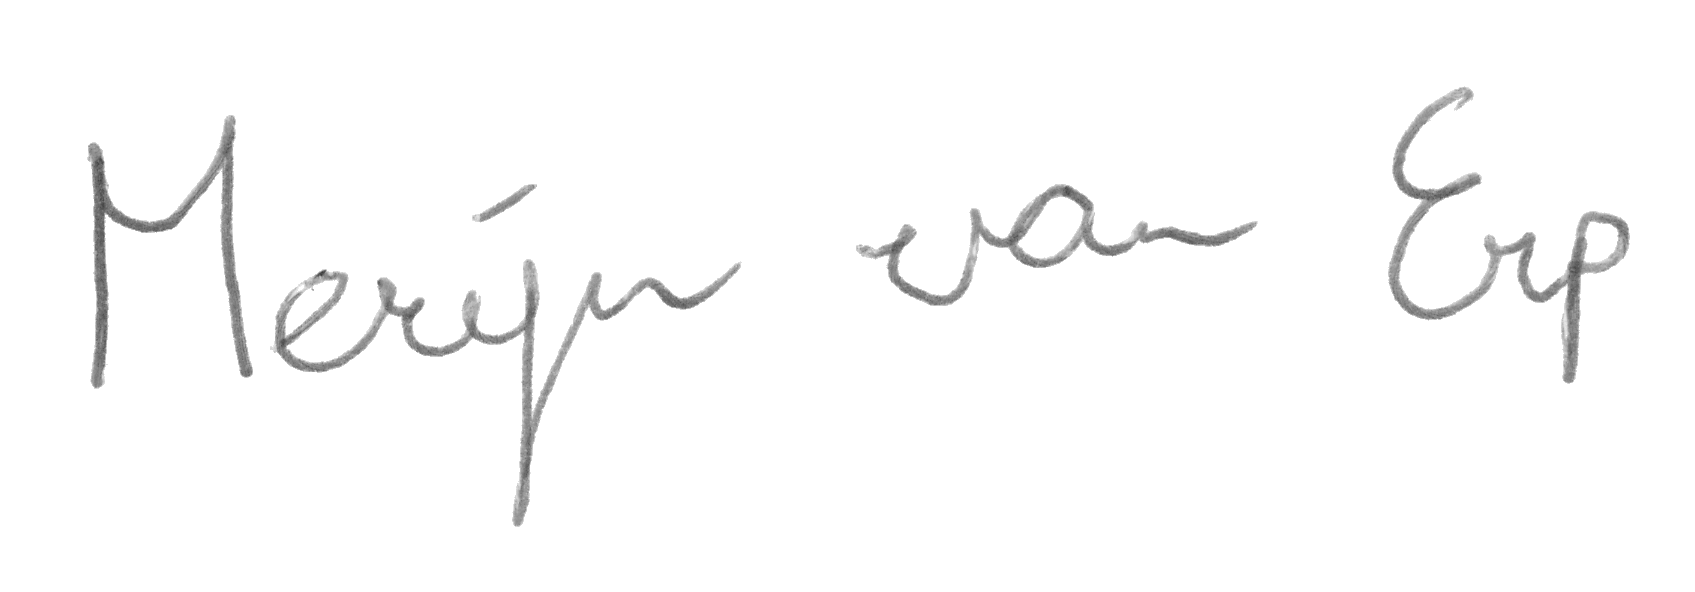

0_06105071.png


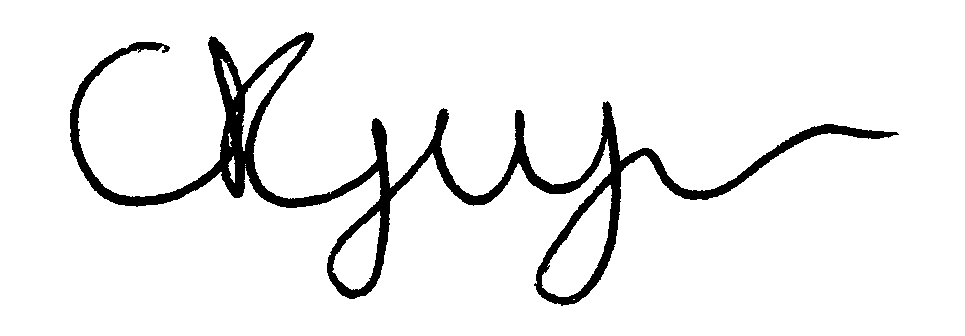

1_00304003.png


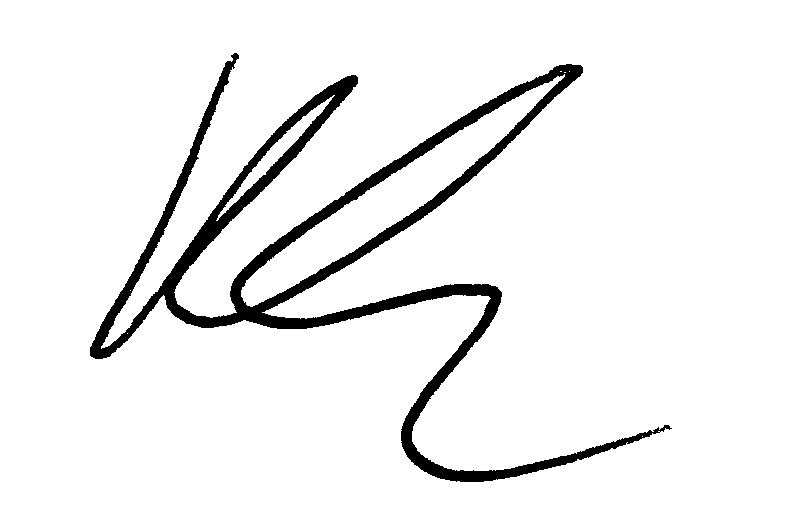

0_02205002.png


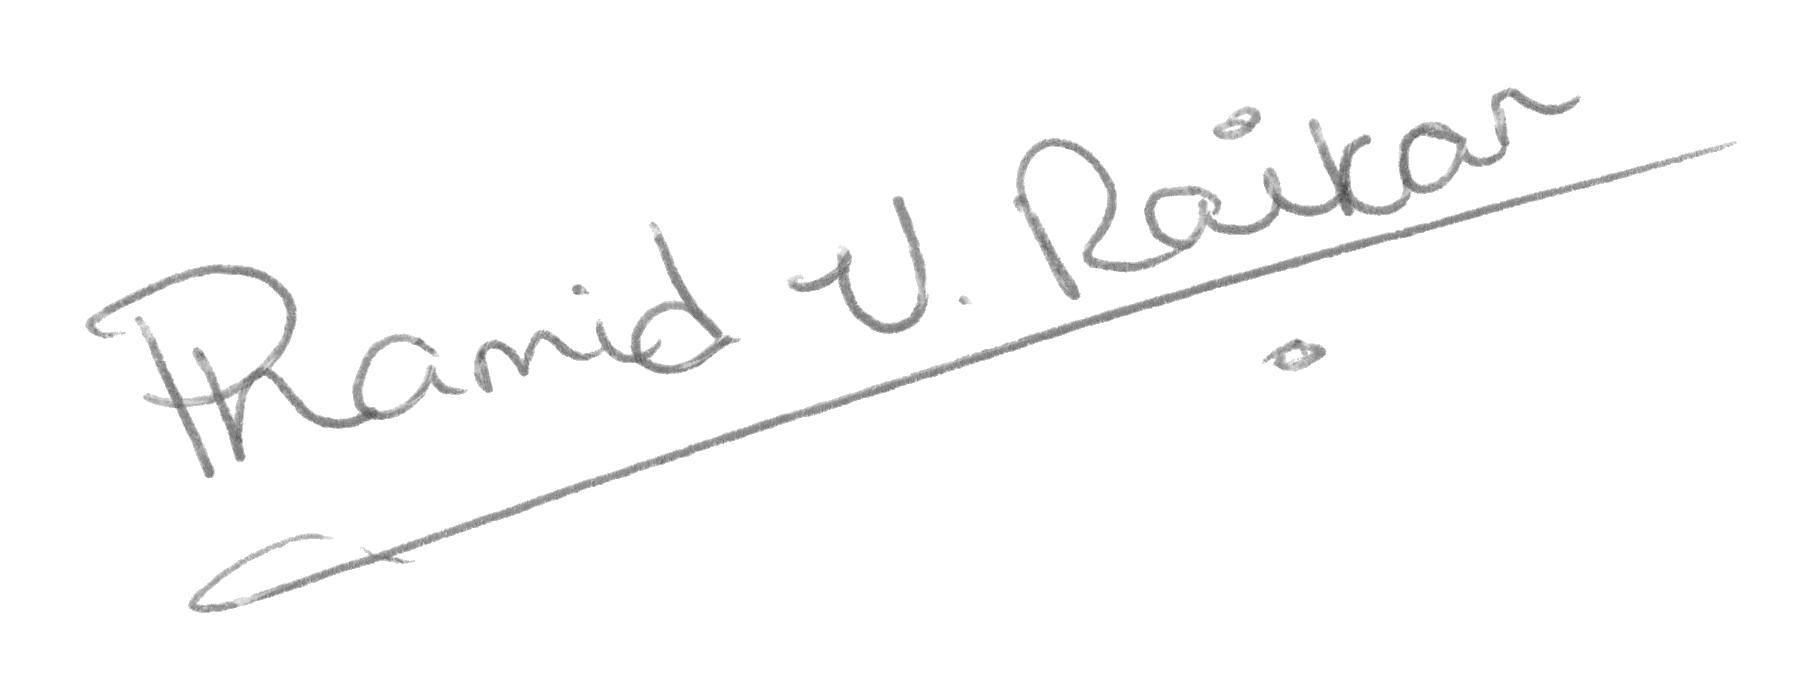

In [2]:
#load from folder
imgs_raw = "dataset_mixed"

files_raw = [f for f in os.listdir(imgs_raw) if os.path.isfile(os.path.join(imgs_raw, f))]


print("Working with {0} signature images".format(len(files_raw)))
print("Image examples: ")

for i in range(0, 5):
    print(files_raw[i])
    display(_Imgdis(filename=imgs_raw + "/" + files_raw[i], width=240, height=320))



In [3]:
def loadImages(folder):
    #put files into lists and return them as one list
    image_files = sorted([os.path.join(folder, file) for file in os.listdir(folder)])
    return image_files

In [4]:
def image_resize(data):
    #getting all images to work with
    img = [cv2.imread(i, cv2.IMREAD_GRAYSCALE) for i in data]
    print('Original size',img[0].shape)
    # --------------------------------
    # setting dim of the resize
    height = 160
    width = 320
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Checcking the size
    print("RESIZED", res_img[1].shape)

    
    return res_img

Original size (58, 171)
RESIZED (160, 320)
[[249 249 248 ... 248 248 248]
 [249 249 248 ... 248 248 248]
 [249 249 248 ... 248 248 248]
 ...
 [249 249 249 ... 247 246 246]
 [249 249 249 ... 247 247 247]
 [249 249 249 ... 247 247 247]]
Signature Images Resized
1_00105001.png


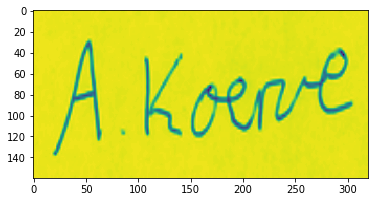

0_02202001.png


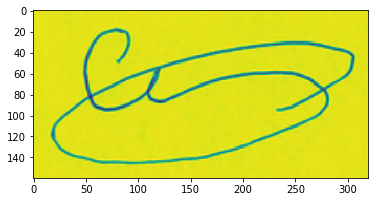

0_06105071.png


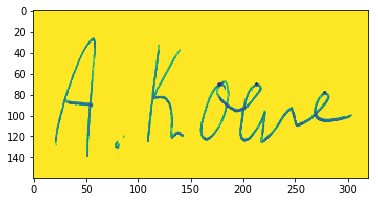

In [5]:
# Segmentation & Morphology
# In this step, we step we are going to segment the image, 
# separating background from foreground objects and we are 
# going to further improve our segmentation with more noise removal.
%matplotlib inline

images = loadImages(imgs_raw)

images_resized= image_resize(images)

print(images_resized[0])
#show image examples
print("Signature Images Resized")
for i in range(0, 3):
    print(files_raw[i])
    #img = cv2.imread(resized_images[i])
    plt.imshow(images_resized[i])
    plt.show()
    

In [6]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_files = [] #list full of file names
train_labels = []
i=0
for _file in files_raw:
    train_files.append(_file)
    label_in_file = _file.find("_")
    train_labels.append(int(_file[0:label_in_file]))
print("Files in train_files: %d" % len(train_files))
print(train_files[0])

Using TensorFlow backend.


Files in train_files: 542
1_00105001.png


In [7]:
from sklearn.model_selection import train_test_split

#Splitting 
train_images, test_images, train_labels, test_labels = train_test_split(images_resized, train_labels, test_size=0.2, random_state=33)
train_images = np.array(train_images)
train_images.shape
test_images = np.array(test_images)
test_images.shape

(109, 160, 320)

In [8]:
train_images = train_images / 255.0

test_images = test_images / 255.0

In [9]:
class_names = [ "forged", "real"]

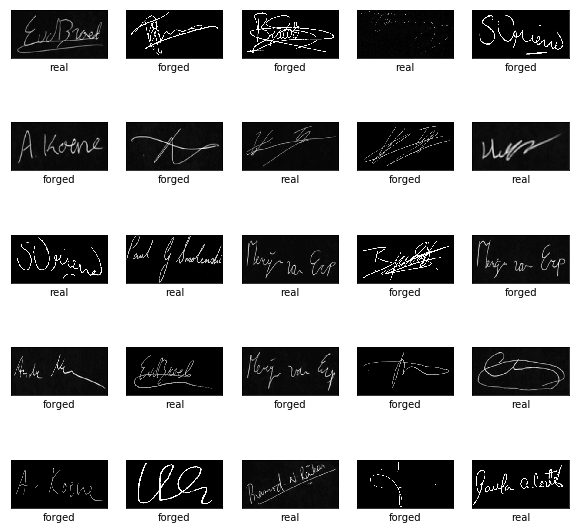

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [11]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(160,320)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
433/433 [==============================] - 2s 5ms/sample - loss: 6.6905 - acc: 0.5289
Epoch 2/5
433/433 [==============================] - 2s 5ms/sample - loss: 6.8865 - acc: 0.5727
Epoch 3/5
433/433 [==============================] - 2s 5ms/sample - loss: 6.8865 - acc: 0.5727
Epoch 4/5
433/433 [==============================] - 2s 5ms/sample - loss: 6.8865 - acc: 0.5727
Epoch 5/5
433/433 [==============================] - 2s 5ms/sample - loss: 6.8865 - acc: 0.5727


In [14]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

109/109 [==============================] - 0s 1ms/sample - loss: 6.9500 - acc: 0.5688
Test accuracy: 0.56880736


In [15]:
predictions = model.predict(test_images)
predictions[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [16]:
np.argmax(predictions[7])
    

0

In [19]:
test_labels[0]

0

In [20]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

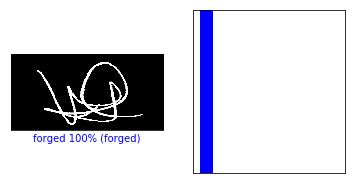

In [21]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

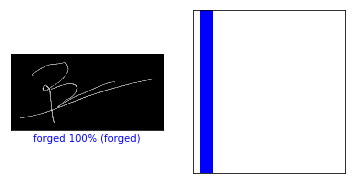

In [22]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

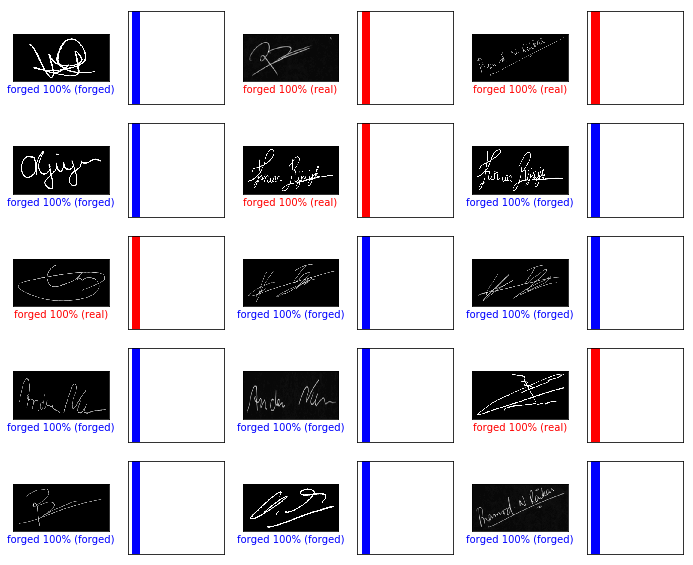

In [23]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()